# Visión artificial
## El muffinómetro

In [1]:
from google.colab import files
import zipfile
import os

#Como estoy trabajando en Google Colab tengo que trabajar con el zip y descomprimirlo
# Subir el archivo comprimido
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/Image_dataset')

# Listar las carpetas descomprimidas
print("Carpetas descomprimidas en /content/Image_dataset:")
print(os.listdir('/content/Image_dataset'))

# Listar archivos en cada carpeta para verificar
carpeta1 = '/content/Image_dataset/cupcake'
carpeta2 = '/content/Image_dataset/muffin'

Saving Image_dataset.zip to Image_dataset.zip
Carpetas descomprimidas en /content/Image_dataset:
['muffin', 'cupcake']


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

1. Descomprima el dataset proporcionado en data/image_dataset.zip.

In [3]:
# Rutas a las carpetas de imágenes
carpeta_muffins = carpeta2
carpeta_cupcake = carpeta1

2. Separe los datos en train y validation (80%/20%).

In [4]:
# Función para listar imágenes con sus etiquetas
def listar_imagenes(carpeta, etiqueta):
    return [[tf.io.gfile.join(carpeta, nombre_archivo), etiqueta]
            for nombre_archivo in tf.io.gfile.listdir(carpeta)
            if nombre_archivo.lower().endswith(('.jpg'))]

# Crear listas de imágenes con sus etiquetas
imagenes_muffins = listar_imagenes(carpeta_muffins, 'muffin')
imagenes_cupcakes = listar_imagenes(carpeta_cupcake, 'cupcake')

# Combinar ambas listas y convertir a DataFrame
df_imagenes = pd.DataFrame(imagenes_muffins + imagenes_cupcakes, columns=['ruta', 'etiqueta'])

# Dividir en conjuntos de entrenamiento y prueba (80/20)
train_df, test_df = train_test_split(df_imagenes, test_size=0.2, stratify=df_imagenes['etiqueta'], random_state=123)

# Mostrar tamaños de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño del conjunto de prueba: {len(test_df)}')

# Verificar las primeras filas de los conjuntos de entrenamiento y prueba
print("Algunos de los datos del set de entrenamiento: ")
print(train_df.head())
print("Algunos de los datos del set de validación: ")
print(test_df.head())

Tamaño del conjunto de entrenamiento: 1323
Tamaño del conjunto de prueba: 331
Algunos de los datos del set de entrenamiento: 
                                                   ruta etiqueta
354      /content/Image_dataset/muffin/images (278).jpg   muffin
330       /content/Image_dataset/muffin/images (67).jpg   muffin
975   /content/Image_dataset/cupcake/flipped_images ...  cupcake
1015  /content/Image_dataset/cupcake/flipped_images ...  cupcake
232        /content/Image_dataset/muffin/image (27).jpg   muffin
Algunos de los datos del set de validación: 
                                                  ruta etiqueta
911    /content/Image_dataset/cupcake/images (298).jpg  cupcake
507     /content/Image_dataset/muffin/images (313).jpg   muffin
299     /content/Image_dataset/muffin/images (153).jpg   muffin
49   /content/Image_dataset/muffin/flipped_images (...   muffin
999  /content/Image_dataset/cupcake/flipped_images ...  cupcake


3. Entrene un modelo usando la siguiente arquitectura (o similar):

8x conv2d 3x3 \
ReLU \
maxpool 2x2 \
dropout 0.4

12x conv2d 3x3 \
ReLU \
maxpool 2x2 \
dropout 0.4

flatten \
1x dense \
sigmoid


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Rutas a las carpetas de imágenes
carpeta_muffins = carpeta2
carpeta_cupcake = carpeta1

# Función para listar imágenes con sus etiquetas
def listar_imagenes(carpeta, etiqueta):
    return [[f"{carpeta}/{nombre_archivo}", etiqueta]
            for nombre_archivo in tf.io.gfile.listdir(carpeta)
            if nombre_archivo.lower().endswith(('.jpg'))]

# Crear listas de imágenes con sus etiquetas
imagenes_muffins = listar_imagenes(carpeta_muffins, 'muffin')
imagenes_cupcakes = listar_imagenes(carpeta_cupcake, 'cupcake')

# Combinar ambas listas y convertir a DataFrame
df_imagenes = pd.DataFrame(imagenes_muffins + imagenes_cupcakes, columns=['ruta', 'etiqueta'])

# Dividir en conjuntos de entrenamiento y prueba (80/20)
train_df, test_df = train_test_split(df_imagenes, test_size=0.2, stratify=df_imagenes['etiqueta'], random_state=123)

# Crear generadores de datos para el entrenamiento y la validación
datagen_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, zoom_range=0.2, rotation_range=20)
# En el set de entrenamiento modifica levemente las fotos, haciendoles zoom o volteándolas así aprende a detecarlas con variaciones y prevenir el overfitting
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    train_df, x_col='ruta', y_col='etiqueta', target_size=(160, 160),
    class_mode='binary', batch_size=32, shuffle=True
)

test_generator = datagen_test.flow_from_dataframe(
    test_df, x_col='ruta', y_col='etiqueta', target_size=(160, 160),
    class_mode='binary', batch_size=32, shuffle=False
)

inp = Input(shape=(160,160,3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=output)
model.summary()


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_generator, epochs=20, validation_data=test_generator)

# Evaluar el modelo
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


Found 1323 validated image filenames belonging to 2 classes.
Found 331 validated image filenames belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 80, 80, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 24)        3480      
                                                                 
 max_p

(4 y 5). Grafique la curva de loss de entrenamiento y validación en función de la epoch. ¿Tiene la forma que esperaba? :Informe la accuracy en el dataset de entrenamiento y el de validación (el modelo debería lograr 80-85% de accuracy en el dataset de validación)


11/11 [==============================] - 3s 227ms/step - loss: 0.3985 - accuracy: 0.8308
Training Loss: 0.38031724095344543
Training Accuracy: 0.8518518805503845
Validation Loss: 0.3985145688056946
Validation Accuracy: 0.8308157324790955


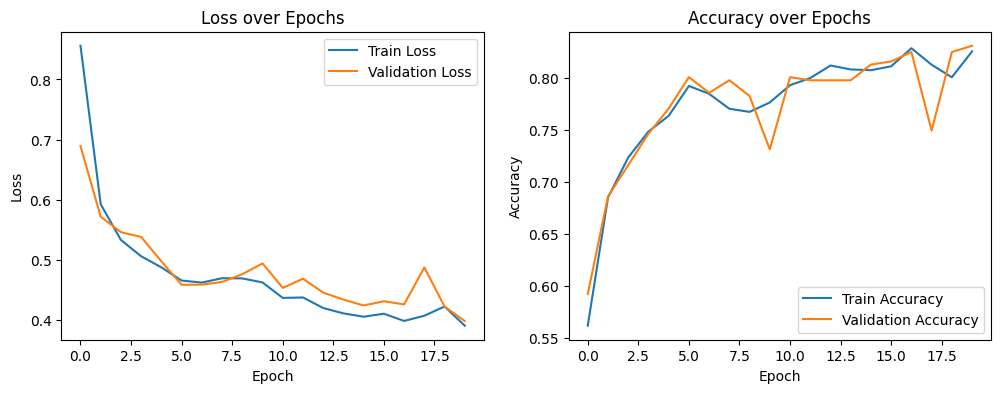

In [6]:
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de entrenamiento y validación
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(test_generator)

print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")



# Graficar loss y accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



plt.show()

Observando las pérdidas y la precisión del modelo en función de las *epochs* se pueden sacar varias conclusiones.
#### **Loss**
Como era de esperar, el *loss* de entrenamiento es mayoritariamente menor o igual que el *loss* de validación. Esto se debe a que cuando el modelo entrena con los datos, con el fin de minimizar la pérdida, va a tener más exito en la reducción del *loss* si se trata de los datos ya vistos previamente que si es con los datos compleamente desconocidos para el modelo (los del test).
#### **Accuracy**
La precisión del modelo tiende a crecer a medida que el modelo va aprendiendo a predecir mejor. Pero si se observa con atención el *plot* es posible apreciar como la precisión de entrenamiento y validación en un principio crecen a la par, pero luego tiende a empeorar levemente (decae como mucho 0.05, lo cual a rasgos generales no es demasiado). Es lógico y esperable que el *set* de entrenamiento tenga mejor precisión, ya que como se mencionó previamente, estos datos son conocidos para el modelo, mientras que los otros no. 

En general, tanto la *loss* como la *accuracy* son mejores en el conjunto de entrenamiento en comparación con el conjunto de validación a lo largo de todas las *epochs*; aunque la diferencia no es abismal, lo cual es un buen indicativo de que el modelo está generalizando correctamente. 

6. Testee su modelo buscando en internet una imagen de un muffin y una de un cupcake. (Estas imágenes no deben estar en el dataset de entrenamiento)

### Para asegurarnos que las imágenes utilizadas no estaban en el dataset de entrenamiento se crearon por una inteligencia artificial.

Saving imagen_misteriosa_1.png to imagen_misteriosa_1 (1).png
1/1 [==============================] - 0s 56ms/step
La imagen imagen_misteriosa_1 (1).png ha sido clasificada como: cupcake


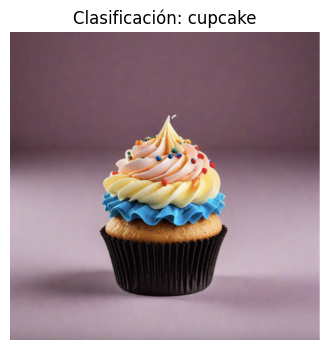

In [14]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def cargar_y_preprocesar_imagen(ruta_imagen):
    img = image.load_img(ruta_imagen, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def clasificar_imagen(ruta_imagen, modelo):
    img_preprocesada = cargar_y_preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(img_preprocesada)
    if prediccion[0] < 0.5:
        clasificacion = 'cupcake'
    else:
        clasificacion = 'muffin'

    # Cargar la imagen original
    img = Image.open(ruta_imagen)

    return clasificacion, img

# Subir una imagen
uploaded = files.upload()

# Iterar sobre las imágenes subidas
for filename in uploaded.keys():
    clasificacion, img = clasificar_imagen(filename, model)
    print(f"La imagen {filename} ha sido clasificada como: {clasificacion}")

    # Mostrar la imagen usando matplotlib en Google Colab
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clasificación: {clasificacion}")
    plt.show()


Saving imagen_misteriosa_2.png to imagen_misteriosa_2.png
1/1 [==============================] - 0s 33ms/step
La imagen imagen_misteriosa_2.png ha sido clasificada como: muffin


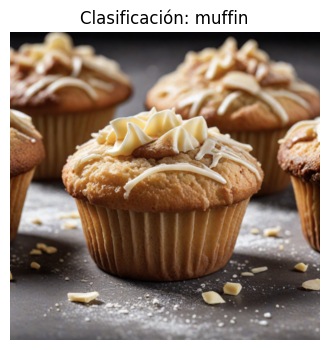

In [12]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def cargar_y_preprocesar_imagen(ruta_imagen):
    img = image.load_img(ruta_imagen, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def clasificar_imagen(ruta_imagen, modelo):
    img_preprocesada = cargar_y_preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(img_preprocesada)
    if prediccion[0] < 0.5:
        clasificacion = 'cupcake'
    else:
        clasificacion = 'muffin'

    # Cargar la imagen original
    img = Image.open(ruta_imagen)

    return clasificacion, img

# Subir una imagen
uploaded = files.upload()

# Iterar sobre las imágenes subidas
for filename in uploaded.keys():
    clasificacion, img = clasificar_imagen(filename, model)
    print(f"La imagen {filename} ha sido clasificada como: {clasificacion}")

    # Mostrar la imagen usando matplotlib en Google Colab
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clasificación: {clasificacion}")
    plt.show()
